In [65]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import svm

In [5]:
df = pd.read_csv('data/diabetes_downsampled.csv')

In [6]:
df.shape

(79757, 22)

In [7]:
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,0,1,25,0,0,0,1,0,...,1,0,2,2,1,0,0,1,5,6
1,0,0,0,1,26,0,0,0,1,0,...,1,0,3,10,0,0,0,1,4,1
2,0,0,0,1,23,0,0,0,1,1,...,1,0,1,0,0,0,0,1,5,3
3,0,0,0,1,28,0,0,0,0,1,...,1,0,1,15,0,0,0,1,5,3
4,0,0,0,1,21,0,0,0,1,0,...,1,0,3,0,14,0,0,1,4,1


### Data Preprocessing

In [8]:
#Remove diabetes instances as we are only interested in non-diabetes and pre-diabetes
#0 is for no diabetes , 1 is for prediabetes, and 2 is for diabetes

In [9]:
df1 = df[(df.Diabetes_012==0) | (df.Diabetes_012==1)]

In [10]:
df1.shape

(44411, 22)

In [11]:
#Number of non-diabetes instances
df1[(df1.Diabetes_012==0)].shape

(39780, 22)

In [12]:
df1[(df1.Diabetes_012==1)].shape

(4631, 22)

In [13]:
df1[(df1.Diabetes_012==0)][df1.columns[0]]

0        0
1        0
2        0
3        0
4        0
        ..
39775    0
39776    0
39777    0
39778    0
39779    0
Name: Diabetes_012, Length: 39780, dtype: int64

#### Data highly unbalanced with only 10.4% of the data as pre-diabetes

## Split Dataset before Data sampling

In [14]:
#Using test_size of 30% of undersampled to split both majority and minority classes to provide a balanced test set
test_size1 = 0.3* df1[(df1.Diabetes_012==1)].shape[0]/df1[(df1.Diabetes_012==0)].shape[0]
test_size2 = 0.3

In [15]:
#split training set
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df1[(df1.Diabetes_012==0)][df1.columns[1:]], df1[(df1.Diabetes_012==0)][df1.columns[0]],
                                                            test_size=test_size1)

In [16]:
X_train_1.shape

(38390, 21)

In [17]:
X_test_1.shape

(1390, 21)

In [18]:
#split test set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df1[(df1.Diabetes_012==1)][df1.columns[1:]], df1[(df1.Diabetes_012==1)][df1.columns[0]],
                                                            test_size=test_size2)

In [19]:
X_train_2.shape

(3241, 21)

In [20]:
X_test_2.shape

(1390, 21)

### merge training splits and test splits

In [21]:
X_train = pd.concat([X_train_1, X_train_2],ignore_index=True)

In [22]:
X_train.shape

(41631, 21)

In [23]:
y_train = pd.concat([y_train_1, y_train_2],ignore_index=True)

In [24]:
y_train.value_counts()

0    38390
1     3241
Name: Diabetes_012, dtype: int64

In [25]:
X_test = pd.concat([X_test_1, X_test_2],ignore_index=True)

In [26]:
X_test.shape

(2780, 21)

In [27]:
y_test = pd.concat([y_test_1, y_test_2],ignore_index=True)

In [28]:
y_test.value_counts()

1    1390
0    1390
Name: Diabetes_012, dtype: int64

#### Undersample majority class

In [29]:
df_train=pd.concat([X_train , y_train], axis = 1).reset_index(drop=True)

In [30]:
df_majority = df_train[df_train.Diabetes_012==0]
df_minority = df_train[df_train.Diabetes_012==1]

In [31]:
# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                      replace=False,    # sample without replacement
                                      n_samples=int(len(df_minority)*1.2),     # to match minority class
                                      random_state=123) # reproducible results

In [32]:
df_majority_downsampled.shape

(3889, 22)

In [33]:
df_train_downsampled = pd.concat([df_majority_downsampled, df_minority],ignore_index=True)

In [34]:
df_train_downsampled

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_012
0,0,1,1,23,0,0,0,1,1,1,...,0,1,0,0,0,0,6,6,8,0
1,1,0,1,30,1,0,0,1,1,1,...,0,1,0,0,0,1,9,5,8,0
2,0,1,1,21,0,0,0,0,0,1,...,0,2,0,0,0,0,4,6,8,0
3,1,1,1,26,1,0,0,1,1,1,...,0,2,0,2,0,1,8,6,8,0
4,1,0,1,27,1,0,0,0,1,0,...,0,2,0,0,0,1,9,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7125,1,1,1,32,1,0,0,1,0,1,...,0,2,0,0,0,1,11,5,7,1
7126,1,1,1,26,1,0,1,0,0,1,...,0,5,0,30,1,1,9,4,7,1
7127,1,0,1,22,0,0,0,0,0,1,...,0,2,0,15,1,0,13,3,4,1
7128,0,0,1,29,0,0,0,1,1,1,...,0,2,0,0,1,0,10,4,8,1


## Data Transformation

In [35]:
df_train_downsampled.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Diabetes_012'],
      dtype='object')

In [36]:
numerical_columns = ['BMI','GenHlth', 'MentHlth', 'PhysHlth','Age', 'Education', 'Income']

In [37]:
categorical_columns = ['HighBP', 'HighChol', 'CholCheck','Smoker', 'Stroke',
        'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
        'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost','DiffWalk', 'Sex',
        'Diabetes_012']

In [38]:
# standardise features
# Create the Scaler object
def standardise(df,num_cols):
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    scaled_df = scaler.fit_transform(df[num_cols])
    scaled_df = pd.DataFrame(scaled_df, columns=num_cols)
    
    return scaler, scaled_df

In [39]:
std_scaler, scaled_df_train = standardise(df_train_downsampled,numerical_columns)
df_train_down_stand = pd.concat([scaled_df_train, df_train_downsampled[categorical_columns]], axis = 1)

In [40]:
df_train_down_stand.head()

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income,HighBP,HighChol,CholCheck,...,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,Diabetes_012
0,-0.907194,-1.527714,-0.45887,-0.512444,-0.580060,1.008514,1.026895,0,1,1,...,0,1,1,1,0,1,0,0,0,0
1,0.146642,-1.527714,-0.45887,-0.512444,0.299093,0.034032,1.026895,1,0,1,...,0,1,1,1,1,1,0,0,1,0
2,-1.208290,-0.586099,-0.45887,-0.512444,-1.166162,1.008514,1.026895,0,1,1,...,0,0,0,1,0,1,0,0,0,0
3,-0.455550,-0.586099,-0.45887,-0.290582,0.006042,1.008514,1.026895,1,1,1,...,0,1,1,1,0,1,0,0,1,0
4,-0.305002,-0.586099,-0.45887,-0.512444,0.299093,-0.940450,-1.790973,1,0,1,...,0,0,1,0,0,1,0,0,1,0


#### Transform test dataset using the standardisation object;std_scaler

In [41]:
scaled_df_test = std_scaler.transform(X_test[numerical_columns])

In [42]:
scaled_df_test = pd.DataFrame(scaled_df_test, columns=numerical_columns)

In [43]:
X_test = pd.concat([scaled_df_test, X_test[categorical_columns[:-1]]], axis = 1)

In [44]:
X_test.head()

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income,HighBP,HighChol,CholCheck,...,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex
0,-0.756646,0.355516,-0.458870,2.815476,1.471296,-0.940450,-0.382039,1,1,1,...,0,1,0,0,1,0,1,0,0,0
1,-0.606098,0.355516,-0.458870,-0.512444,1.471296,-1.914932,0.557250,1,0,1,...,0,0,1,1,0,0,1,0,0,1
2,-1.208290,1.297131,-0.458870,-0.512444,0.885194,-0.940450,-1.790973,1,0,1,...,0,0,1,0,0,0,1,0,0,0
3,-0.003906,-0.586099,-0.074306,-0.512444,-1.752263,1.008514,1.026895,1,1,1,...,0,0,1,0,0,0,1,0,0,1
4,-0.003906,-1.527714,0.053882,-0.512444,-1.166162,1.008514,0.557250,0,1,1,...,0,0,1,0,1,0,0,0,0,1


## Train Machine Learning Models

In [45]:
X_train = df_train_down_stand[df_train_down_stand.columns[:-1]]

In [46]:
y_train = df_train_down_stand[df_train_down_stand.columns[-1]]

In [47]:
X_train

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income,HighBP,HighChol,CholCheck,...,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex
0,-0.907194,-1.527714,-0.45887,-0.512444,-0.580060,1.008514,1.026895,0,1,1,...,0,0,1,1,1,0,1,0,0,0
1,0.146642,-1.527714,-0.45887,-0.512444,0.299093,0.034032,1.026895,1,0,1,...,0,0,1,1,1,1,1,0,0,1
2,-1.208290,-0.586099,-0.45887,-0.512444,-1.166162,1.008514,1.026895,0,1,1,...,0,0,0,0,1,0,1,0,0,0
3,-0.455550,-0.586099,-0.45887,-0.290582,0.006042,1.008514,1.026895,1,1,1,...,0,0,1,1,1,0,1,0,0,1
4,-0.305002,-0.586099,-0.45887,-0.512444,0.299093,-0.940450,-1.790973,1,0,1,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7125,0.447738,-0.586099,-0.45887,-0.512444,0.885194,0.034032,0.557250,1,1,1,...,0,0,1,0,1,0,1,0,0,1
7126,-0.455550,2.238745,-0.45887,2.815476,0.299093,-0.940450,0.557250,1,1,1,...,0,1,0,0,1,0,1,0,1,1
7127,-1.057742,-0.586099,-0.45887,1.151516,1.471296,-1.914932,-0.851684,1,0,1,...,0,0,0,0,1,0,1,0,1,0
7128,-0.003906,-0.586099,-0.45887,-0.512444,0.592144,-0.940450,1.026895,0,0,1,...,0,0,1,1,1,0,1,0,1,0


In [48]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
7125    1
7126    1
7127    1
7128    1
7129    1
Name: Diabetes_012, Length: 7130, dtype: int64

In [49]:
X_test

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income,HighBP,HighChol,CholCheck,...,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex
0,-0.756646,0.355516,-0.458870,2.815476,1.471296,-0.940450,-0.382039,1,1,1,...,0,1,0,0,1,0,1,0,0,0
1,-0.606098,0.355516,-0.458870,-0.512444,1.471296,-1.914932,0.557250,1,0,1,...,0,0,1,1,0,0,1,0,0,1
2,-1.208290,1.297131,-0.458870,-0.512444,0.885194,-0.940450,-1.790973,1,0,1,...,0,0,1,0,0,0,1,0,0,0
3,-0.003906,-0.586099,-0.074306,-0.512444,-1.752263,1.008514,1.026895,1,1,1,...,0,0,1,0,0,0,1,0,0,1
4,-0.003906,-1.527714,0.053882,-0.512444,-1.166162,1.008514,0.557250,0,1,1,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,0.146642,-0.586099,-0.458870,-0.512444,1.178245,0.034032,-1.321328,1,1,1,...,1,1,0,1,1,0,1,0,0,0
2776,-0.756646,2.238745,-0.458870,0.596863,1.471296,-0.940450,-1.321328,0,1,1,...,1,0,1,1,1,0,1,0,1,0
2777,1.049930,1.297131,-0.458870,-0.512444,0.885194,1.008514,1.026895,1,1,1,...,0,0,0,1,1,0,1,0,0,0
2778,-1.208290,-0.586099,-0.330682,-0.512444,1.471296,1.008514,1.026895,0,0,1,...,0,0,1,1,1,0,1,0,0,0


In [50]:
y_test

0       0
1       0
2       0
3       0
4       0
       ..
2775    1
2776    1
2777    1
2778    1
2779    1
Name: Diabetes_012, Length: 2780, dtype: int64

## Machine learning models

#### Gradient Boost

In [52]:
# Number of trees in random forest
n_estimators = [100,300,500]

#evaluation criteria
criterion=['friedman_mse', 'mse']

# Number of features to consider at every split
max_features = [1,0.5,0.1]
max_features.append('auto')

# Maximum number of levels in tree
max_depth = [3, 6, 12]

# Minimum number of samples required to split a node
min_samples_split = [2, 10, 20, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 8]

In [53]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': criterion,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

In [54]:
GB = GradientBoostingClassifier()

#### Random Forest

In [81]:
# Number of trees in random forest
n_estimators = [100,200,300]

#information gain algorithm
criterion=['gini','entropy']

# Number of features to consider at every split
max_features = [1,0.5,0.1]
max_features.append('auto')

# Maximum number of levels in tree
max_depth = [10,50,100]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 10, 20, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 8]

In [82]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': criterion,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

In [91]:
RF = RandomForestClassifier()

#### Extra Trees

In [83]:
ET = ExtraTreesClassifier()

### XGBoost

In [51]:
# Number of trees in random forest
n_estimators = [100,300,500]

#information gain algorithm
objective = ['binary:logistic']

# Maximum number of levels in tree
max_depth = [4, 10, 20]

alpha = [5, 10, 20]

#Specify which booster to use: gbtree, gblinear or dart
booster = ['gbtree','gblinear'] 

#learning rate
learning_rate = [1.0, 0.01, 0.001]

#evaluation metric
eval_metric = ['error', 'logloss']

In [52]:
param_grid = {
    'objective':objective,
    'max_depth': max_depth,
    'alpha': alpha,
    'learning_rate': learning_rate,
    'n_estimators':n_estimators,
    'booster': booster,
    'eval_metric': eval_metric
}

In [53]:
XGB = XGBClassifier(use_label_encoder=False)

#### Support Vector Machine

In [66]:
#penalty parameter i.e. kernel margin: Large C->small margin
C= [1, 10, 100]

#kernel type
kernel = ['linear', 'poly', 'rbf', 'sigmoid' ]

#degree of polynomial kernel
degree =  [2,3,4,5]

In [67]:
#Hyperparameter optimization
param_grid ={
    'C': C,
    'kernel': kernel,
    'degree':  degree
}

In [68]:
svc=svm.SVC(gamma='auto')

### Optimisation

In [69]:
# Instantiate the grid search model
search = GridSearchCV(estimator = svc , param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [79]:
# Instantiate the random search model
search = RandomizedSearchCV(estimator = RF, param_distributions = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [70]:
# Fit the grid search to the data
search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=SVC(gamma='auto'), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'degree': [2, 3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

In [71]:
print(search.best_params_)

{'C': 1, 'degree': 2, 'kernel': 'rbf'}


In [72]:
best_ML = search.best_estimator_

## Evaluate our trained model

In [73]:
# Training and Test Accuracies
best_ML.fit(X_train, y_train)
y_val_train=best_ML.predict(X_train)
y_val_test=best_ML.predict(X_test)

In [74]:
#Training Classification Report
print(classification_report(y_train,y_val_train))
print(confusion_matrix(y_train,y_val_train))
print(accuracy_score(y_train,y_val_train))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      3889
           1       0.69      0.73      0.71      3241

    accuracy                           0.72      7130
   macro avg       0.72      0.72      0.72      7130
weighted avg       0.73      0.72      0.73      7130

[[2816 1073]
 [ 890 2351]]
0.7246844319775596


In [75]:
#Test Classification Report
print(classification_report(y_test,y_val_test))
print(confusion_matrix(y_test,y_val_test))
print(accuracy_score(y_test,y_val_test))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1390
           1       0.71      0.72      0.71      1390

    accuracy                           0.71      2780
   macro avg       0.71      0.71      0.71      2780
weighted avg       0.71      0.71      0.71      2780

[[977 413]
 [396 994]]
0.7089928057553957


### Explain the importance of features in the trained model predictions

In [62]:
importances = best_ML.feature_importances_

In [63]:
feat_importances = pd.Series(importances, index=X_train.columns)

In [64]:
feat_importances = feat_importances.sort_values(ascending=False)

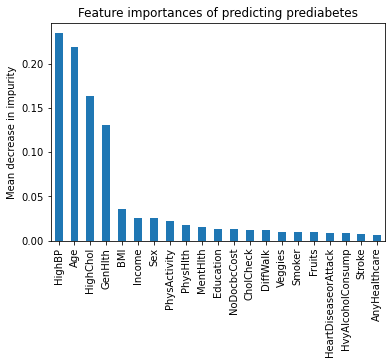

In [65]:
feat_importances.plot.bar()
plt.title("Feature importances of predicting prediabetes")
plt.ylabel("Mean decrease in impurity")
plt.show()
